## Notebook that should cleanly look at the results of recent optimisations

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
import sys
import jax.numpy as jnp

from NRT_functions import losses
from NRT_functions import helper_functions
from NRT_functions import plotters

# %cd /Users/will/Documents/Neural_Rep_Theory/11_June_Norm/

In [ ]:
day = '251106'
time = '170735'
counter = 0
save_fig = 0
plot_scale = 1

if counter == '':
  adding_string = ''
else:
  adding_string = '_'

%cd /home/julian/Projects/MasterThesis/ICLR_Actionable_Reps
filepath = './data/' + day + '/' + time + '/'
%cd "$filepath"

# Load parameters from JSON instead of pickle
with open('parameters.json', 'r') as json_file:
    parameters = json.load(json_file)

with open('W' + adding_string + f'{counter}.pkl', 'rb') as pickle_file:
    W = pickle.load(pickle_file)

with open('om'+ adding_string + f'{counter}.pkl', 'rb') as pickle_file:
    om = pickle.load(pickle_file)
#om = helper_functions.freq_selector(100)
with open('min_L'+ adding_string + f'{counter}.pkl', 'rb') as pickle_file:
    min_L = pickle.load(pickle_file)

with open('L'+ adding_string + f'{counter}.pkl', 'rb') as pickle_file:
    L = pickle.load(pickle_file)

with open('W_init'+ adding_string + f'{counter}.pkl', 'rb') as pickle_file:
    W_init = pickle.load(pickle_file)

W_final = W
#with open('W_final'+ adding_string + f'{counter}.pkl', 'rb') as pickle_file:
#    W_final = pickle.load(pickle_file)

if "pos_lengthscale" not in parameters:
  parameters["pos_lengthscale"] = 2
if "dim" not in parameters:
  parameters["dim"] = 1
if min_L[0] < 1:
  W = W_final

if parameters["dim"] == 1:
    # RESULTS PLOTTER
    N_plot = 1000 # Number of angles for the plot
    RowsD = 4
    ColumnsD = int(np.ceil(parameters["D"]/RowsD))
    to_save = 0

    if "epsilon_w" in parameters:
        phi_plot_large = np.linspace(-np.pi, np.pi, N_plot)*parameters["pos_lengthscale"] # Angle inputs
        phi_plot_small = np.linspace(-np.pi, np.pi, N_plot)
        I_large = helper_functions.init_irreps_1D(om, phi_plot_large)
        I_small = helper_functions.init_irreps_1D(om, phi_plot_small)
        V_large = np.matmul(W, I_large)
        V_small = np.matmul(W, I_small)
        small_norms = np.linalg.norm(V_small, axis = 1)
        large_norms = np.linalg.norm(V_large, axis = 1)
        V_small = V_small/large_norms[:,None]
        V_large = V_large/large_norms[:,None]
        N = V_large.shape[0]

        if "sampling_choice" in parameters and parameters["sampling_choice"] == 1:
            phi_calc = np.random.normal(0, 1, N_plot)
        else:
            phi_calc = phi_plot_small

        neur_losses = np.zeros(N)
        if parameters["sep_loss_choice"] == 0:
            loss = losses.sep_line_Euc(W, om, phi_calc)
            for neuron in range(N):
                neur_losses[neuron] = losses.sep_line_Euc(W[neuron,:][None,:], om, phi_calc)
        elif parameters["sep_loss_choice"] == 1:
            chi = helper_functions.calc_chi_line(phi_calc, parameters["sigma_theta"], parameters["f"])
            loss = losses.sep_line_EucChi(W, om, phi_calc, chi)
            for neuron in range(N):
                neur_losses[neuron] = losses.sep_line_EucChi(W[neuron,:][None,:], om, phi_calc, chi)
        elif parameters["sep_loss_choice"] == 2:
            loss = losses.sep_line_Kern(W, om, phi_calc, parameters["sigma_sq"])
            for neuron in range(N):
                neur_losses[neuron] = losses.sep_line_Kern(W[neuron,:][None,:], om, phi_calc, parameters["sigma_sq"])  

        Vs = [V_small, V_large]
        phi_plots = [phi_plot_small, phi_plot_large]

        om_scrunch_threshold = 0.4
        thresh_percentage = 1
        fig = plotters.freq_plot(W, om, thresh_percentage, om_scrunch_threshold, parameters)
        fig.savefig("freq_plot.svg")
    else:
        phi_plot = np.linspace(-np.pi, np.pi, N_plot); # Angle inputs
        I_plot = helper_functions.init_irreps_1D(om, phi_plot)
        V = np.matmul(W, I_plot)
        N = V.shape[0]

        if parameters["sample_choice"] == 0:
            I_loss = I_plot
        elif parameters["sample_choice"] == 1:
            phi_loss = np.random.sample(N_plot)*parameters["spread"]
            I_loss = helper_functions.init_irreps_1D(om, phi_loss)


        neur_losses = np.zeros(N)
        if parameters["sep_loss_choice"] == 0:
            loss = losses.sep_circ_Euc(W, I_loss)
            #for neuron in range(N):
            #  neur_losses[neuron] = losses.sep_circ_Euc(W[neuron,:], I_loss)
        elif parameters["sep_loss_choice"] == 1:
            chi = helper_functions.calc_chi_circ(phi_plot, parameters["sigma_theta"], parameters["f"])
            loss = losses.sep_circ_EucChi(W, I_loss, chi)
            for neuron in range(N):
                neur_losses[neuron] = losses.sep_circ_EucChi(W[neuron,:][None,:], I_loss, chi)
        elif parameters["sep_loss_choice"] == 2:
            loss = losses.sep_circ_Kern(W, I_loss, parameters["sigma_sq"])   
            for neuron in range(N):
                neur_losses[neuron] = losses.sep_circ_Kern(W[neuron,:][None,:], I_loss, parameters["sigma_sq"])
        elif parameters["sep_loss_choice"] == 3:
            chi = helper_functions.calc_chi_line(phi_plot, parameters["sigma_theta"], parameters["f"])
            loss = losses.sep_circ_KernChi(W, I_loss, parameters["sigma_sq"], chi)
            for neuron in range(N):
                neur_losses[neuron] = losses.sep_circ_KernChi(W[neuron,:][None,:], I_loss, parameters["sigma_sq"], chi)

        Vs = [V]
        phi_plots = [phi_plot]

        fig = plotters.freq_plot_1D(W_init, W)
        if to_save:
            plotters.saveFigure(fig, day, time, "FreqPlot_Norms")

        for (plot_counter, V_plot) in enumerate(Vs):
            phi_here = phi_plots[plot_counter]
            plot_min = min(np.min(V_plot), np.min(V_plot))
            plot_max = max(np.max(V_plot), np.max(V_plot)) 
            fig, ax = plt.subplots(RowsD, ColumnsD)
            [axi.set_axis_off() for axi in ax.ravel()]
            for neuron in range(N):
                plt.subplot(RowsD,ColumnsD,neuron+1)
                plt.title(f"{neur_losses[neuron]:.6f}")
                plt.plot(phi_here, V_plot[neuron,:])
                plt.ylim([plot_min, plot_max])
                """plt.tick_params(
                    axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False) # labels along the bottom edge are off
                plt.tick_params(
                    axis='y',          # changes apply to the y-axis
                    which='both',      # both major and minor ticks are affected
                    left=False,      # ticks along the bottom edge are off
                    right=False,         # ticks along the top edge are off
                    labelleft=False) # labels along the bottom edge are off
                """
            fig.set_figheight(10)
            fig.set_figwidth(15)
            #plt.suptitle(f'Time: {min_L[0]:.0f}, Loss: {min_L[2]:.5f}, calc: {loss}')
            #plt.savefig(filepath+"response.jpeg")
            plot_counter = plot_counter + 1
            plt.show()
            fig.savefig(f"Neurons_Plot_{plot_counter}.svg")

        #if to_save:
        #    plotters.saveFigure(fig, day, time, "Responses")
        #display(fig)

elif parameters["dim"] == 2:
    fig = plotters.freq_plot(W, om, 1.1, 1, parameters)
    fig.savefig("freq_plot.svg")
    

    if "epsilon_w" in parameters:
        N_plot = 70
        phi_plot_small = np.linspace(-np.pi, np.pi, N_plot)/2
        phi_plot_small = np.meshgrid(phi_plot_small, phi_plot_small)
        phi_plot_small = np.hstack([np.ndarray.flatten(phi_plot_small[0])[:,None], np.ndarray.flatten(phi_plot_small[1])[:,None]])
        phi_plot_large = np.linspace(-np.pi, np.pi, N_plot)*parameters["pos_lengthscale"]*plot_scale # Angle inputs
        phi_plot_large = np.meshgrid(phi_plot_large, phi_plot_large)
        phi_plot_large = np.hstack([np.ndarray.flatten(phi_plot_large[0])[:,None], np.ndarray.flatten(phi_plot_large[1])[:,None]])
        I_large = helper_functions.init_irreps_2D(om, phi_plot_large)
        I_small = helper_functions.init_irreps_2D(om, phi_plot_small)
        V_large = np.matmul(W, I_large)
        V_small = np.matmul(W, I_small)
        small_norms = np.linalg.norm(V_small, axis = 1)
        large_norms = np.linalg.norm(V_large, axis = 1)
        V_small = V_small/large_norms[:,None]
        V_large = V_large/large_norms[:,None]
        N = V_large.shape[0]

        if parameters["sampling_choice"] == 1:
          phi_calc = np.random.normal(0, 1, [N_plot*N_plot, 2])
        elif parameters['sampling_choice'] == 0 or parameters['sampling_choice'] == 2:
            r = np.sqrt(np.random.uniform(size=[N_plot*N_plot, 1]))
            theta = np.random.uniform(size=[N_plot*N_plot, 1]) * 2 * np.pi
            phi_calc = np.hstack([r * np.cos(theta), r * np.sin(theta)])
        else:
          phi_calc = phi_plot_small

        neur_losses = np.zeros(N)
        if parameters["sep_loss_choice"] == 0:
          loss = losses.sep_plane_Euc(W, om, phi_calc)
          #for neuron in range(N):
            #neur_losses[neuron] = losses.sep_plane_Euc(W[neuron,:][None,:], om, phi_calc)
        elif parameters["sep_loss_choice"] == 1:
          chi = helper_functions.calc_chi_plane(phi_calc, parameters["sigma_theta"], parameters["f"])
          loss = losses.sep_plane_EucChi(W, om, phi_calc, chi)
          for neuron in range(N):
            neur_losses[neuron] = losses.sep_plane_EucChi(W[neuron,:][None,:], om, phi_calc, chi)
        elif parameters["sep_loss_choice"] == 2:
          loss = losses.sep_plane_Kern(W, om, phi_calc, parameters["sigma_sq"])
          for neuron in range(N):
            neur_losses[neuron] = losses.sep_plane_Kern(W[neuron,:][None,:], om, phi_calc, parameters["sigma_sq"])
        elif parameters["sep_loss_choice"] == 3:
            chi = helper_functions.calc_chi_plane(phi_calc, parameters["sigma_theta"], parameters["f"])
            #loss = losses.sep_plane_KernChi(W, om, phi_calc, parameters["sigma_sq"], chi)
            #for neuron in range(N):
                #neur_losses[neuron] = losses.sep_plane_KernChi(W[neuron,:][None,:], om, phi_calc, parameters["sigma_sq"], chi)   

        Vs = [V_small, V_large]
        phi_plots = [phi_plot_small, phi_plot_large]

    else:
        N_plot = 150
        phi_plot = np.linspace(-np.pi, np.pi, N_plot)
        phi_plot = np.meshgrid(phi_plot, phi_plot)
        phi_plot = np.transpose(np.vstack([np.ravel(phi_plot[0]),np.ravel(phi_plot[1])]))
        I_plot = helper_functions.init_irreps_2D(om, phi_plot)
        V_plot = np.matmul(W, I_plot)

        phi_calc = np.linspace(-np.pi, np.pi, int(N_plot/5))
        phi_calc = np.meshgrid(phi_calc, phi_calc)
        phi_calc = np.transpose(np.vstack([np.ravel(phi_calc[0]),np.ravel(phi_calc[1])]))
        I_calc = helper_functions.init_irreps_2D(om, phi_calc)
        V_calc = np.matmul(W, I_calc)
        N = V_calc.shape[0]

        neur_losses = np.zeros(parameters["D"])
        if parameters["sep_loss_choice"] == 0:
          loss = losses.sep_circ_Euc(W, I_calc)
          for neuron in range(parameters["D"]):
            neur_losses[neuron] = losses.sep_circ_Euc(W[neuron,:][None,:], I_calc)
        elif parameters["sep_loss_choice"] == 1:
          chi = helper_functions.calc_chi_line(phi_plot, parameters["sigma_theta"], parameters["f"])
          loss = losses.sep_circ_Euc(W, om, phi_plot, chi)
          for neuron in range(N):
            neur_losses[neuron] = losses.sep_circ_EucChi(W[neuron,:][None,:], om, phi_plot, chi)
        elif parameters["sep_loss_choice"] == 2:
          loss = losses.sep_circ_Kern(W, I_calc, parameters["sigma_sq"])
          for neuron in range(N):
            neur_losses[neuron] = losses.sep_circ_Kern(W[neuron,:][None,:], I_calc, parameters["sigma_sq"]) 
        elif parameters["sep_loss_choice"] == 3:
            chi = helper_functions.calc_chi_line(phi_plot, parameters["sigma_theta"], parameters["f"])
            #loss = losses.sep_circ_KernChi(W, om, phi_plot, parameters["sigma_sq"], chi)


        Vs = [V_plot]
        phi_plots = [phi_plot]

    RowsD = int(np.ceil(np.sqrt(parameters["D"])))
    ColumnsD = int(np.ceil(parameters["D"]/RowsD))
    plot_counter = 0
    for (plot_counter, V_plot) in enumerate(Vs):
        fig = plt.figure(figsize = (20, 16))
        for neuron in range(parameters["D"]):
            plt.subplot(RowsD, ColumnsD, neuron + 1)
            plt.axis('off')
            plt.imshow(np.reshape(V_plot[neuron,:], [N_plot,N_plot]), vmin=V_plot.min(), vmax=V_plot.max())
            plt.colorbar()
            plt.title(f"{neur_losses[neuron]:.3f}")
            #plt.colorbar()
        #plt.suptitle(loss)
        fig.tight_layout()
        plot_counter = plot_counter + 1
        plt.show()
        fig.savefig(f"Neurons_Plot_{plot_counter}.svg")
        #print(loss)
        if parameters["sep_loss_choice"] < 2:
            print(parameters["D"]*min(neur_losses))

    
# Plot up the losses
titles = ['Loss', 'Separation', 'Positivity', 'Norm']
fig2 = plt.figure(figsize = (12, 8))
for counter in range(4):
    plt.subplot(1,4,counter+1)
    plt.plot(L[counter,:])
    plt.title(titles[counter])
plt.suptitle(f'Min Loss: {min_L[1]:.3f}')
fig2.savefig(f"Losses.svg")
plt.show()
parameters

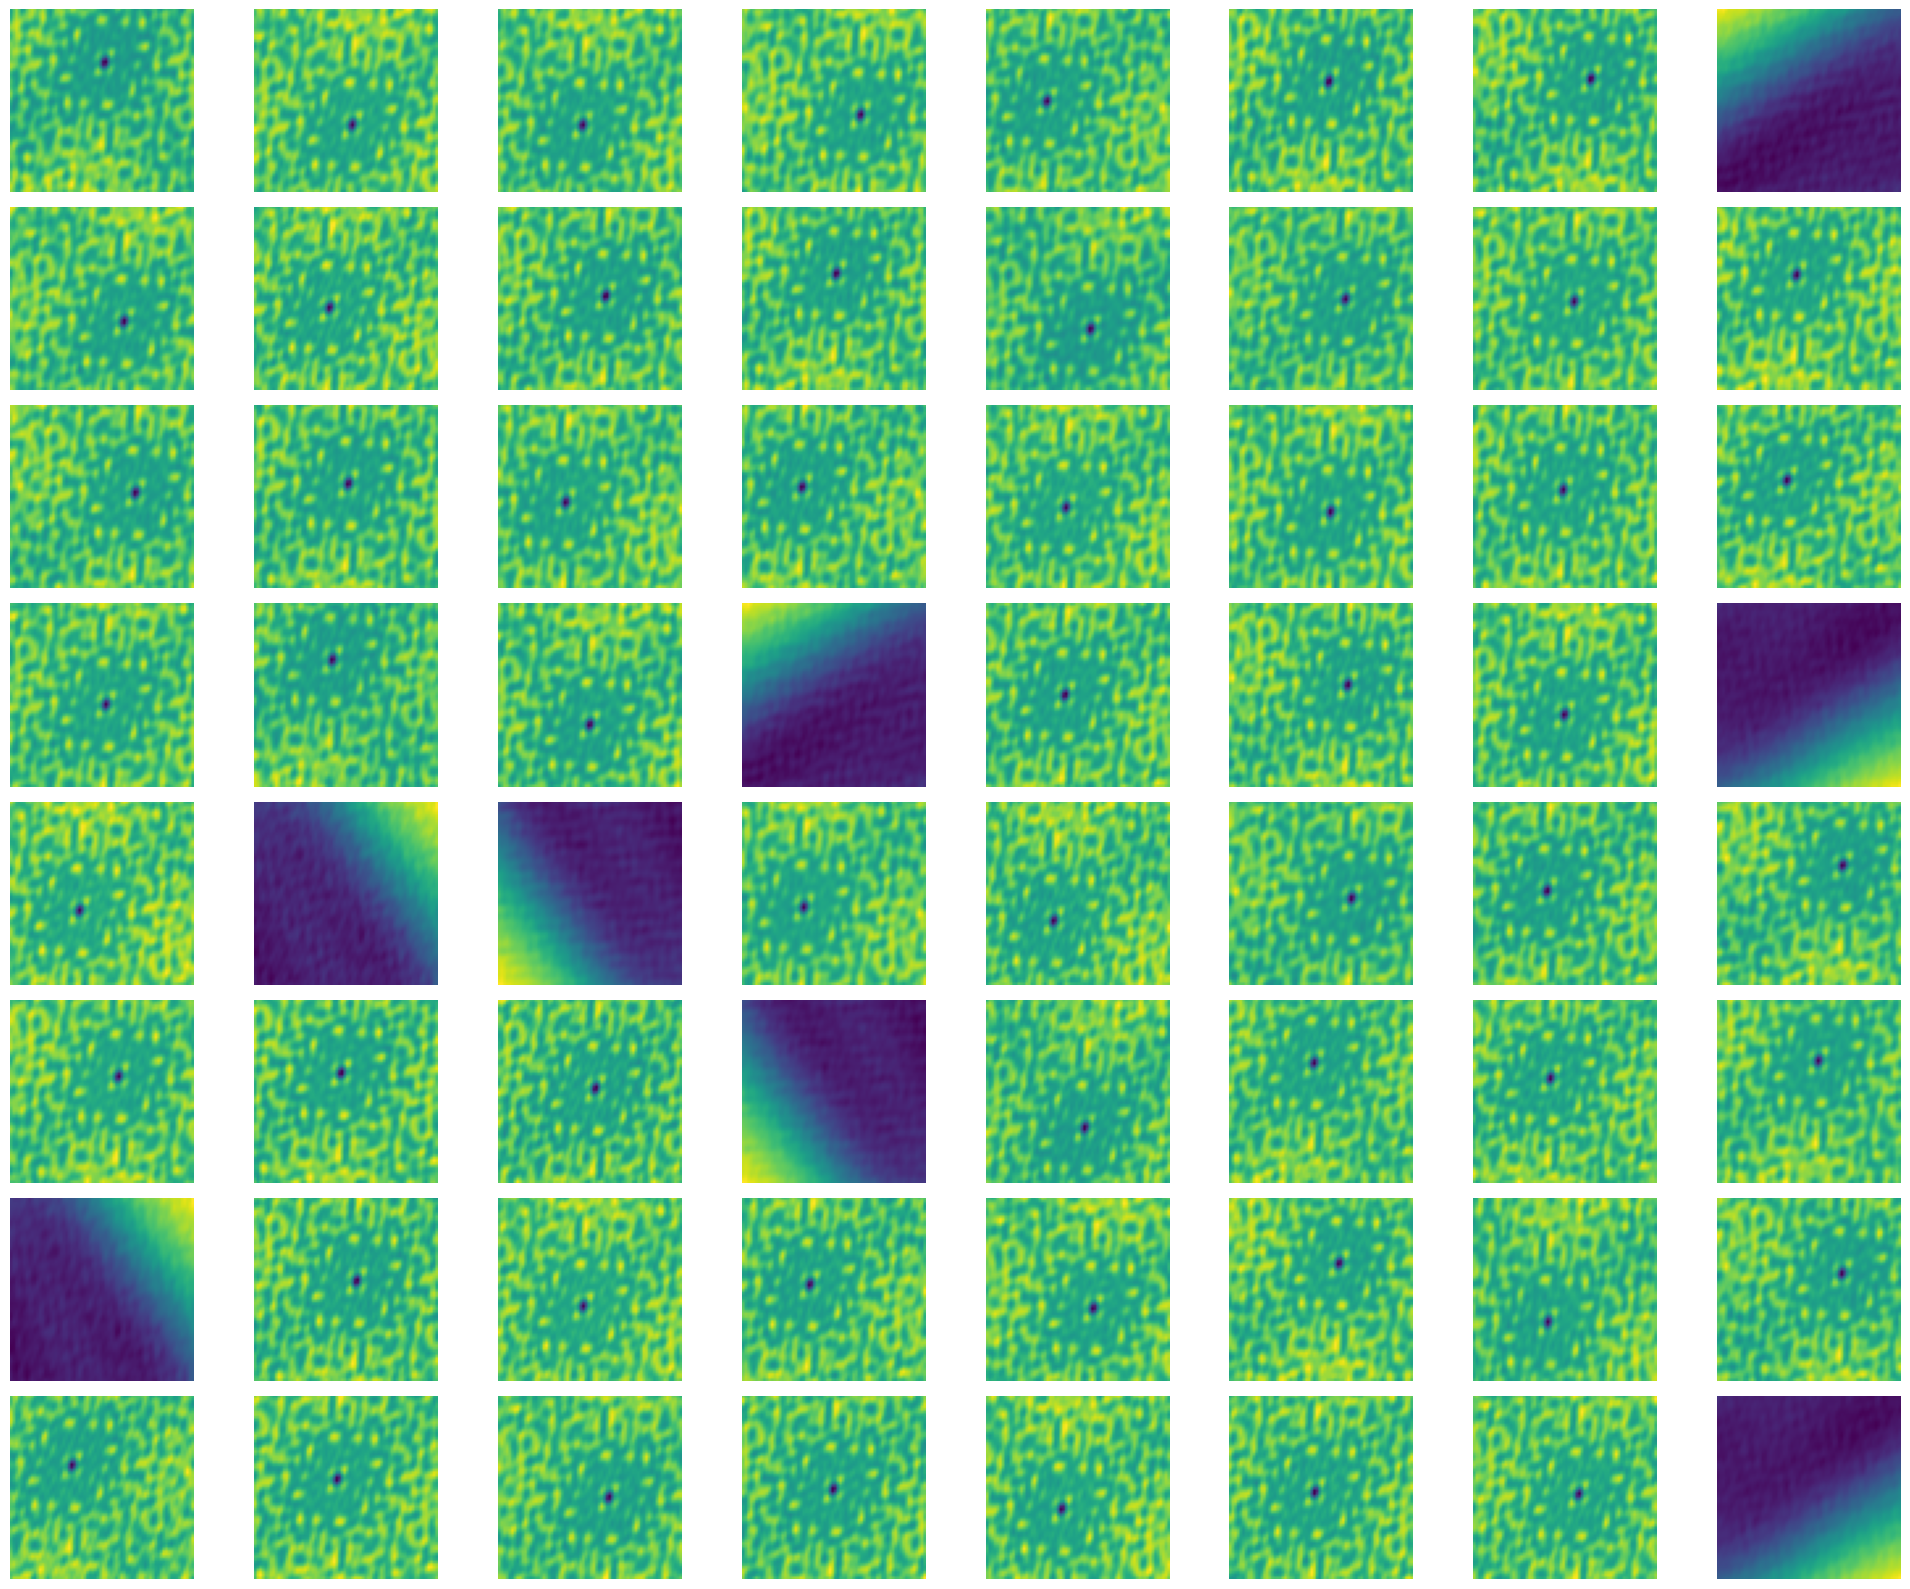

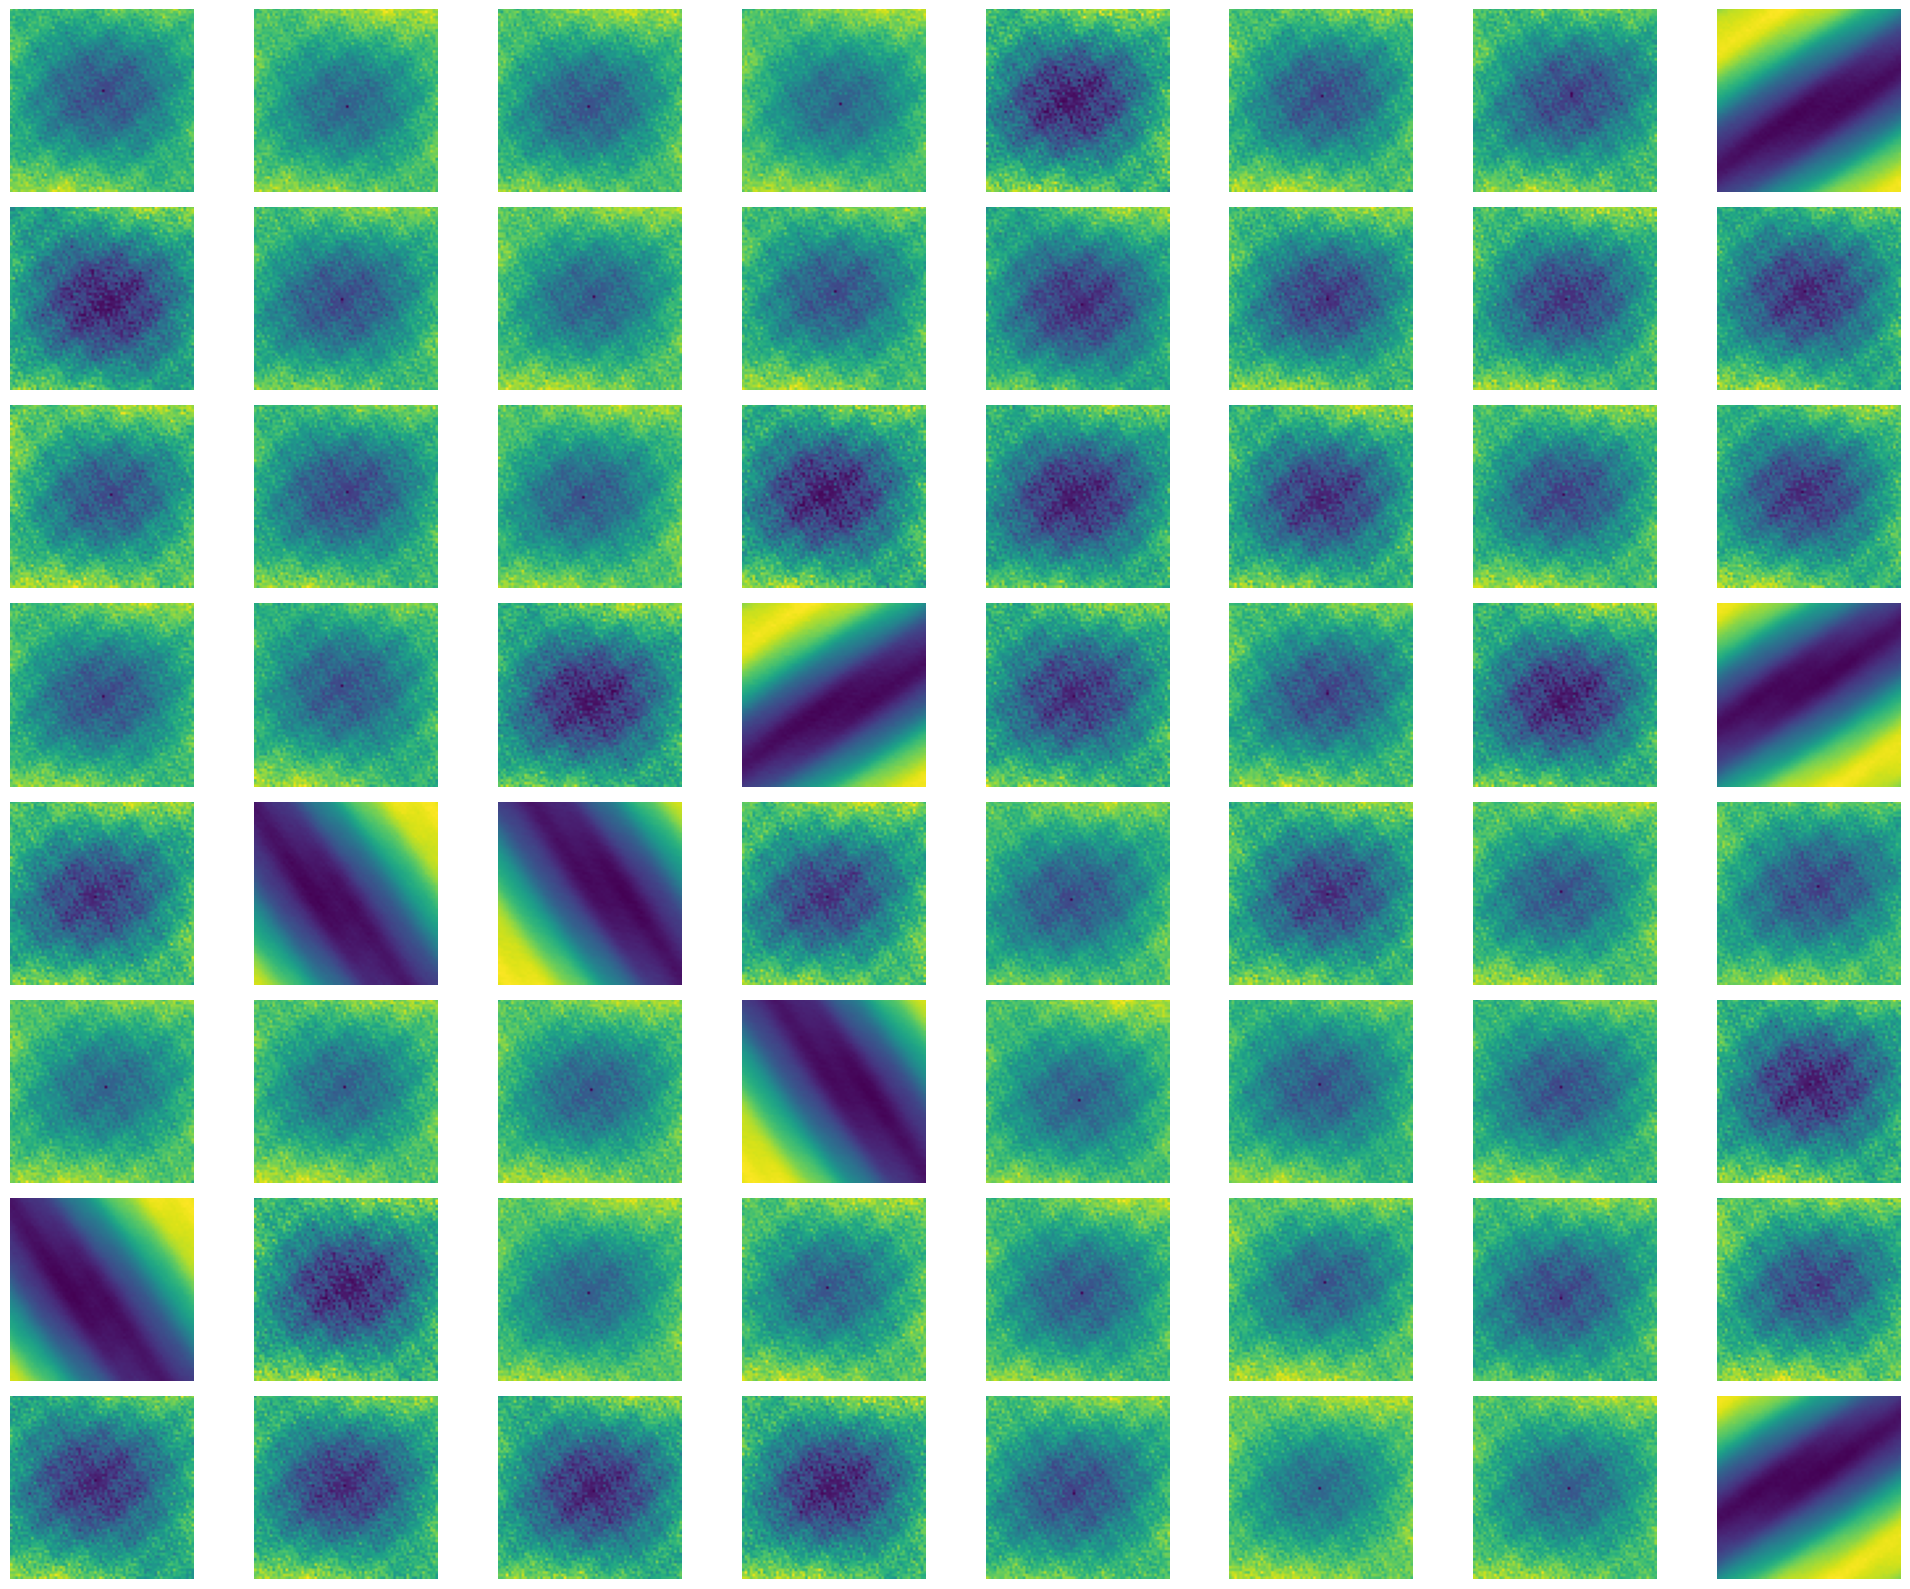

In [3]:
for (plot_counter, V_plot) in enumerate(Vs):
    fig = plt.figure(figsize = (20, 16))
    for neuron in range(parameters["D"]):
        plt.subplot(RowsD, ColumnsD, neuron + 1)
        plt.axis('off')
        plt.imshow(np.reshape(V_plot[neuron,:], [N_plot,N_plot]))
        #plt.title(f"{neur_losses[neuron]:.3f}")
        #plt.colorbar()
        ax = plt.gca()
        ax.patch.set_edgecolor('black')  

        ax.patch.set_linewidth('10')  
    #plt.suptitle(loss)
    fig.tight_layout()
    plot_counter = plot_counter + 1
    plt.show()
    fig.savefig(f"Neurons_Plot_{plot_counter}.svg")
    #print(loss)
    if parameters["sep_loss_choice"] < 2:
        print(parameters["D"]*min(neur_losses))



In [4]:
parameters

{'D': 64,
 'T': 150000,
 'K': 1,
 'N_rand': 150,
 'N_shift': 15,
 'resample_iters': 5,
 'save_iters': 5,
 'lambda_pos_init': 0.1,
 'k_p': -9,
 'alpha_p': 0.9,
 'gamma_p': 0.0001,
 'lambda_norm_init': 0.005,
 'k_norm': 6,
 'alpha_norm': 0.9,
 'gamma_norm': 0.0001,
 'beta1': 0.9,
 'beta2': 0.9,
 'eta': 1e-08,
 'epsilon_w': 0.1,
 'epsilon_om': 0.1,
 'dim': 2,
 'sampling_choice': 1,
 'norm_size': 1,
 'Shift_std': 3,
 'shift_points_sep': 0,
 'om_init_scheme': 0,
 'om_init_scale': 2,
 'sigma_sq': 0.04,
 'sigma_theta': 0.5,
 'f': 1,
 'chi_choice': 0,
 'sep_loss_choice': 3,
 'pos_lengthscale': 2}

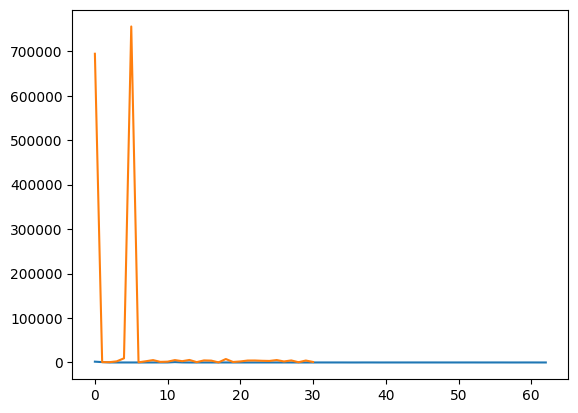

In [5]:
plt.plot(np.linalg.norm(W_final, axis = 0))
weights = np.linalg.norm(W_final, axis = 0)[1:]
weights = weights[::2]**2 + weights[1::2]**2
plt.plot(weights)

In [6]:
om[weights > 0.01,:]

Array([[  0.20254815,   0.36315706],
       [  3.4441617 ,  19.999865  ],
       [  6.958465  ,  27.617859  ],
       [ 25.157904  ,   2.811487  ],
       [  1.6195712 ,   2.056501  ],
       [  0.26681507,  -0.22076918],
       [ 36.771538  ,  -5.1124797 ],
       [  8.97454   ,  11.948874  ],
       [ -2.003899  ,  12.370384  ],
       [ 38.994213  ,   6.9935327 ],
       [ 31.771969  ,  -1.7480099 ],
       [  2.971814  ,  15.434573  ],
       [ 18.63811   , -13.506802  ],
       [-11.537741  ,   5.697865  ],
       [ 36.006702  ,  11.205104  ],
       [ -8.327962  ,  14.343774  ],
       [ 17.533747  ,  -5.8100443 ],
       [ -0.33885077,  30.445107  ],
       [ 17.210903  ,   3.442353  ],
       [  8.665373  ,  21.70502   ],
       [ 26.682543  ,  -6.95839   ],
       [ 13.391254  ,  20.36402   ],
       [ 29.973082  ,   3.371405  ],
       [ 25.467104  ,   8.371145  ],
       [ -5.0445538 ,  20.53568   ],
       [  2.2365746 ,  -1.4216644 ],
       [  2.9570286 ,  23.04281   ],
 

In [7]:
def init_irreps_2D(om, phi):
    cos_stack = jnp.cos(jnp.sum(phi[None,:,:]*om[:,None,:], axis = 2))
    sin_stack = jnp.sin(jnp.sum(phi[None,:,:]*om[:,None,:], axis = 2))
    I = jnp.ones([2*jnp.shape(om)[0] + 1, jnp.shape(phi)[0]])
    I = I.at[1::2,:].set(cos_stack)
    I = I.at[2::2,:].set(sin_stack)
    return I


In [8]:
# Sample a load of points
N_plot = 50
phi_plot_large = np.linspace(-np.pi, np.pi, N_plot)
phi_plot_large = np.meshgrid(phi_plot_large, phi_plot_large, phi_plot_large)
phi_plot_large = np.hstack([np.ndarray.flatten(phi_plot_large[0])[:,None], np.ndarray.flatten(phi_plot_large[1])[:,None], np.ndarray.flatten(phi_plot_large[2])[:,None]])

I = init_irreps_2D(om, phi_plot_large)
V = np.matmul(W_final, I)

TypeError: mul got incompatible shapes for broadcasting: (1, 125000, 3), (31, 1, 2).

In [ ]:
fig = plt.figure(figsize = (16, 6))

for neuron in range(5):
    ax = fig.add_subplot(2, 5, neuron + 1, projection='3d')

    ax.scatter(phi_plot_large[:,0],  phi_plot_large[:,1], phi_plot_large[:,2], c = V[neuron,:], alpha = 0.3)

    ax.view_init(elev=45, azim=45)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.get_zaxis().set_ticks([])
    
plt.savefig('3D_Grids.svg')

In [ ]:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(1, 1,  1, projection='3d')
ax.scatter(phi_plot_large[:,0],  phi_plot_large[:,1], phi_plot_large[:,2], c = V[neuron,:], alpha = 0.3)